### Исследование посетителей сайта

In [21]:
#Импортируем библиотеки
import json 
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

#Задаем необходимые параметры для запроса к Яндекс.Метрике
token = 'y0_AQAAAABjzbrxAAhSRgAAAADLeXue6m1bxVOZSMiw5nR6v6aekQcMVz8'
headers = {'Authorization': 'OAuth ' + token}

params = {'metrics': 'ym:s:visits,ym:s:robotPercentage',
          'dimensions': 'ym:s:lastsignTrafficSource,ym:s:hour',  
          'date1': '2020-09-01',  
          'date2': '2020-09-30',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}

#Создаем запрос и проверяем код ответа
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
print (response.status_code)

200


In [22]:
#Переводим ответ в json-формат
metrika_data = response.json()

#Создаем функцию для избавления от вложенных словарей
def getMetrikaDataInListOfDicts(metrika_data):
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts

metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)

#Преобразуем данные в DataFrame
metrika_df = pd.DataFrame(metrika_list_of_dicts)

#Переименуем столбцы
metrika_df.columns = ['Source','Time','Visits','RobotPercentage']

display(metrika_df.head())

,Source,Time,Visits,RobotPercentage
0,Search engine traffic,16:00,251.0,24.701195
1,Search engine traffic,15:00,240.0,26.250000
2,Search engine traffic,11:00,228.0,25.877193
3,Search engine traffic,13:00,227.0,28.193833
4,Search engine traffic,12:00,225.0,24.888889


In [23]:

#Подготовим данные для проведения анализа
#Добавим столбцы с количеством посещений людьми и роботами и временем суток посещения
metrika_df['People'] = metrika_df['Visits'] * (1 - metrika_df['RobotPercentage'] / 100)
metrika_df['Robots'] = metrika_df['Visits'] * metrika_df['RobotPercentage'] / 100

#Создадим функцию для определения времени суток
def time_of_day (hour):
    night = ['00:00','01:00','02:00','03:00','04:00','05:00']
    morning = ['06:00','07:00','08:00','09:00','10:00','11:00']
    day = ['12:00','13:00','14:00','15:00','16:00','17:00']
    evening = ['18:00','19:00','20:00','21:00','22:00','23:00']
    if hour in night: return 'night'
    elif hour in morning: return 'morning'
    elif hour in day: return 'day'
    else: return 'evening'

#Добавим столбец с временем суток
metrika_df['DayTime'] = metrika_df['Time'].apply(time_of_day)

display(metrika_df.head())

,Source,Time,Visits,RobotPercentage,People,Robots,DayTime
0,Search engine traffic,16:00,251.0,24.701195,189.0,62.0,day
1,Search engine traffic,15:00,240.0,26.250000,177.0,63.0,day
2,Search engine traffic,11:00,228.0,25.877193,169.0,59.0,morning
3,Search engine traffic,13:00,227.0,28.193833,163.0,64.0,day
4,Search engine traffic,12:00,225.0,24.888889,169.0,56.0,day


'Всего за сентябрь 2020 года сайт посетили 962.0 робота и 3353.0 людей'

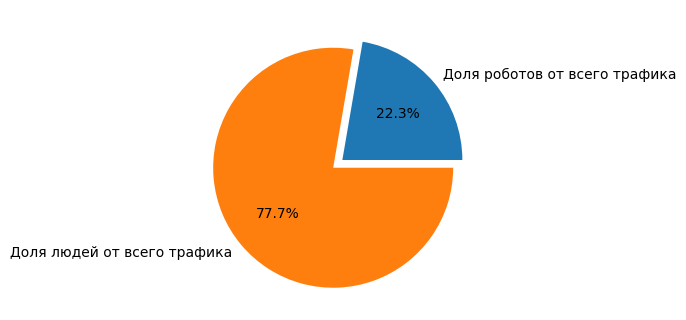

In [24]:
#Определим, сколько людей и роботов посетили сайт
sum_robots = round((metrika_df['Robots'].sum()),0)
sum_people = round((metrika_df['People'].sum()),0)
display(f'Всего за сентябрь 2020 года сайт посетили {sum_robots} робота и {sum_people} людей')

#Построим круговую диаграмму для наглядного отображения результатов
fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    [sum_robots, sum_people],
    labels=['Доля роботов от всего трафика', 'Доля людей от всего трафика'],
    autopct='%.1f%%',
    explode = [0, 0.1]
);

In [25]:
#Создадим сводную таблицу с количеством посещений людей и роботов в зависимости от источника трафика
pivot_sourse = metrika_df.pivot_table(
                                        index='Source', 
                                        values=('Visits', 'People','Robots'), 
                                        aggfunc=sum
                                        )
pivot_sourse['RobotPercentage'] = round((pivot_sourse['Robots'] / (pivot_sourse['Robots'] + pivot_sourse['People'])*100),2)
pivot_sourse

,People,Robots,Visits,RobotPercentage
Source,,,,
Cached page traffic,5.0,1.0,6.0,16.67
Direct traffic,580.0,177.0,757.0,23.38
Internal traffic,7.0,3.0,10.0,30.00
Link traffic,95.0,31.0,126.0,24.60
Recommendation system traffic,2.0,0.0,2.0,0.00
Search engine traffic,2595.0,739.0,3334.0,22.17
Social network traffic,69.0,11.0,80.0,13.75


Наибольшая доля роботов от всех посещений сайта у источника Internal traffic (30%),  но при этом общее количество посещений (10 визитов) достаточно мало по сравнению с другими источниками. На втором месте по доле роботов источник Link traffic (24,6%), на третьем Direct traffic (23,38%). У источника Search engine traffic с наибольшим количеством визитов (3334) доля роботов близка к средней доле от всего трафика (22,17%)

In [26]:
#Построим сводную таблицу посещений роботов по источникам и по времени суток
pivot_day_time=metrika_df.pivot_table(
                                        index='Source', 
                                        columns='DayTime', 
                                        values='Robots', 
                                        aggfunc=sum, 
                                        fill_value='0', 
                                        margins=True)

pivot_day_time

DayTime,day,evening,morning,night,All
Source,,,,,
Cached page traffic,0,0,0,1.0,1.0
Direct traffic,65,54.0,42,16.0,177.0
Internal traffic,2,0,1,0.0,3.0
Link traffic,11,5.0,14,1.0,31.0
Recommendation system traffic,0,0,0,0,0.0
Search engine traffic,358,175.0,169,37.0,739.0
Social network traffic,5,4.0,2,0.0,11.0
All,441.0,238.0,228.0,55.0,962.0


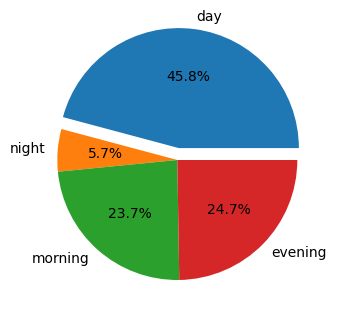

In [27]:
#Построим круговую диаграмму для наглядного отображения результатов

fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    [
    pivot_day_time.loc['All', 'day'], 
    pivot_day_time.loc['All', 'night'], 
    pivot_day_time.loc['All', 'morning'], 
    pivot_day_time.loc['All', 'evening']
    ],
    labels=['day', 'night', 'morning', 'evening'],
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0]
);

Наибольшее количество посещений роботов (441 визит или 45,8%) приходится на дневное время (с 12:00 до 18:00). Наименьшее количество посещений (55 визитов или 5,7%) на ночное время (с 00:00 до 06:00). Утром и вечером количество посещений роботов примерно одинаковое.
